---

> $Rishita$ $Shah$ $2347143$<br/>
 $LAB:$ $NNDL$ <br/>
 $Lab$  $ETE Component 3$ <br/>
 $Question$ $1$

---



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


## LSTM AutoEncoder

#### 1. Load the dataset: The dataset will contain a single column temperature and a date column.

In [2]:
data = pd.read_csv('/content/drive/MyDrive/NNDL/weather_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2557 non-null   object 
 1   temperature  2557 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.1+ KB


In [4]:
data.isna().sum()

,0
date,0
temperature,0


- There are no null values in the dataset

In [5]:
data.head()

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091


In [6]:
# Ensure columns 'Date' and 'Temperature' are present
if 'date' in data.columns and 'temperature' in data.columns:
    print("Dataset loaded successfully with Date and Temperature columns.")
else:
    raise ValueError("Dataset does not have the required columns 'Date' and 'Temperature'.")


Dataset loaded successfully with Date and Temperature columns.


       temperature
count  2557.000000
mean     10.017472
std       0.923047
min       3.337291
25%       9.335195
50%      10.031778
75%      10.681384
max      15.587945


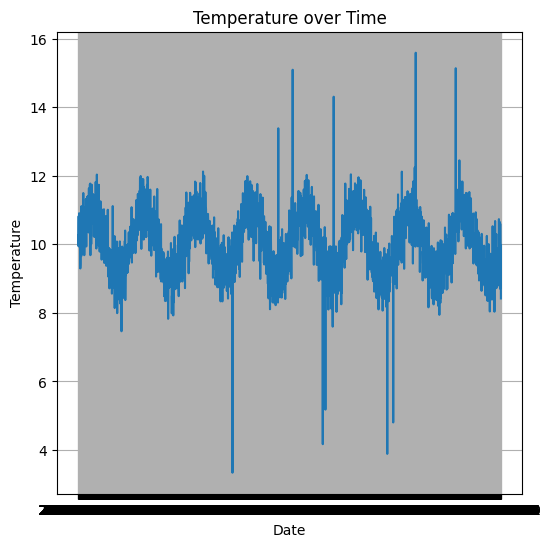

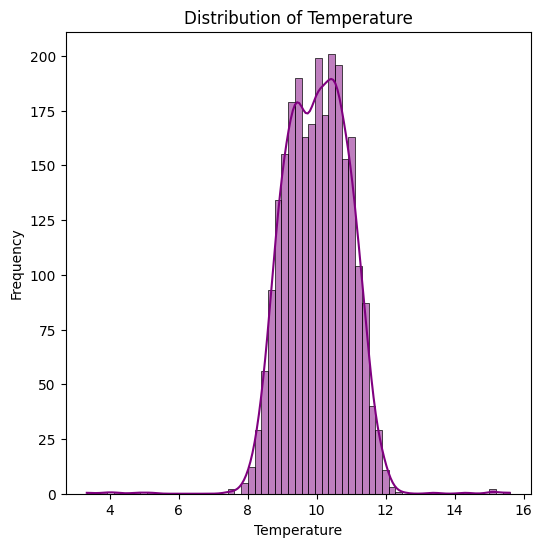

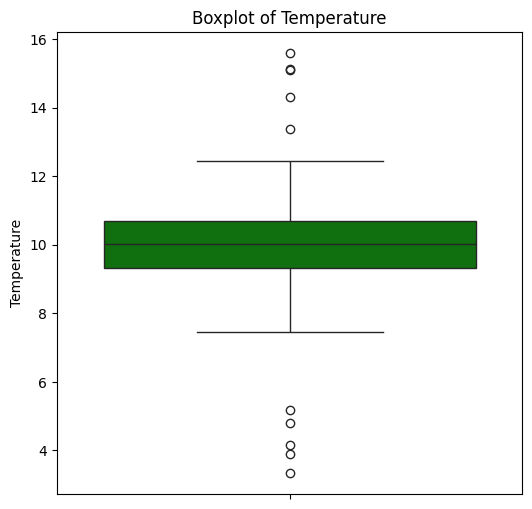

In [7]:
# 1. Data Overview
print(data.describe())

# 2. Time Series Plot of Temperature
plt.figure(figsize=(6, 6))
plt.plot(data['date'], data['temperature'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()


# 3. Distribution of Temperature
plt.figure(figsize=(6, 6))
sns.histplot(data['temperature'], kde=True, color='purple')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature')
plt.show()


# 4. Boxplot of Temperature (Optional, to check for outliers)
plt.figure(figsize=(6, 6))
sns.boxplot(y=data['temperature'], color='green')
plt.ylabel('Temperature')
plt.title('Boxplot of Temperature')
plt.show()


##### Interpretations:

1. **Time Series Plot of Temperature:** This plot shows the temperature values over the date range in the dataset.There are repeated patterns,that could suggest seasonal variations.  Sudden spikes or dips could signal unusual weather events.

2. **Distribution of Temperature:** The histogram shows the frequency distribution of temperature values. The central tendency (mean, median) and the spread (standard deviation) can be estimated visually. A normal distribution indicates typical weather patterns.

3. **Boxplot of Temperature:**  The boxplot provides a summary of the temperature data's distribution, including the median, quartiles (25th and 75th percentiles), and potential outliers.  The "whiskers" extend to the most extreme data points. The points beyond the whiskers are flagged as potential outliers, which could be due to errors in the data or genuine unusual events.

#### 2. Preprocess the data: Normalize the temperature data and split it into training and testingts.

In [8]:
# Convert 'Date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort data by date
data = data.sort_values(by='date')

# Normalize the temperature data
scaler = MinMaxScaler()
data['temperature'] = scaler.fit_transform(data[['temperature']])

# Split into training and testing sets (80-20 split)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print(data.info())
print("----------------------------------------------------")
print(f"Training data size: {len(train_data)}, Testing data size: {len(test_data)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2557 non-null   datetime64[ns]
 1   temperature  2557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB
None
----------------------------------------------------
Training data size: 2045, Testing data size: 512


- The `date` field has been changed from object type to `datetime`

#### 3. Build an LSTM Autoencoder:
o The encoder should reduce the input dimensions to a latent representation.

o The decoder should reconstruct the input from the latent representation.

In [9]:
timesteps = 30
features = 1

# Function to create sequences from the time-series data
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

# Build the LSTM Autoencoder
# Encoder
encoder_inputs = Input(shape=(timesteps, features), name="encoder_input")
encoded = LSTM(64, activation='relu', return_sequences=False, name="encoder_lstm")(encoder_inputs)
latent_space = Dense(32, activation='relu', name="latent_representation")(encoded)  # Latent representation

# Decoder
decoder_inputs = RepeatVector(timesteps, name="repeat_latent")(latent_space)
decoded = LSTM(64, activation='relu', return_sequences=True, name="decoder_lstm")(decoder_inputs)
decoder_outputs = TimeDistributed(Dense(features), name="decoder_output")(decoded)

# Autoencoder Model
autoencoder = Model(encoder_inputs, decoder_outputs, name="LSTM_Autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Extract the Encoder Model for latent representation
encoder = Model(encoder_inputs, latent_space, name="Encoder")


Model: "LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_lstm (LSTM)                  │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_representation (Dense)        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_latent (RepeatVector)         │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_lstm (LSTM)                  │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (TimeDistributed)     │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,873 (171.38 KB)

 Trainable params: 43,873 (171.38 KB)

 Non-trainable params: 0 (0.00 B)

#### 4. Train the model: Train the autoencoder on the training data and evaluate the reconstruction error on the test set.

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.1544 - val_loss: 0.0153
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0125 - val_loss: 0.0055
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0

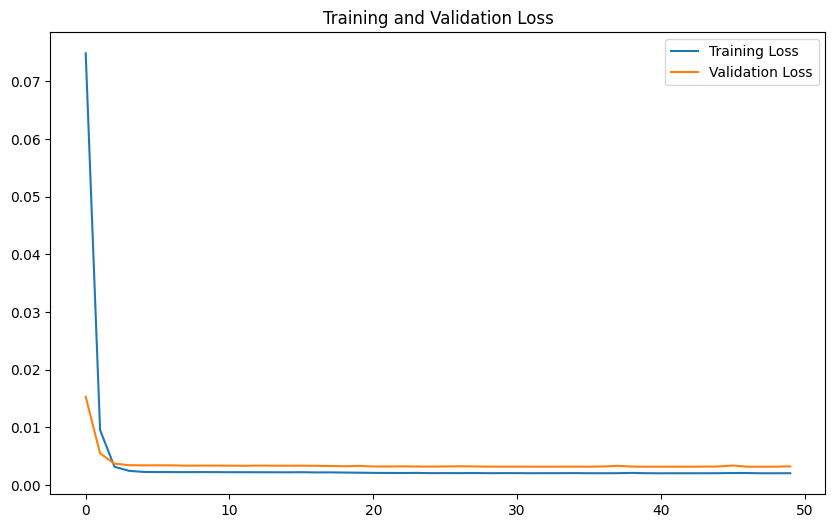

In [11]:
# Prepare training and testing sequences
X_train = create_sequences(train_data['temperature'].values, timesteps)
X_test = create_sequences(test_data['temperature'].values, timesteps)

# Reshape sequences to match LSTM input format: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], timesteps, features))
X_test = X_test.reshape((X_test.shape[0], timesteps, features))

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()



##### Training and Validation Loss Interpretation:

This plot is crucial for assessing the performance of the LSTM autoencoder.

- **Decreasing Loss:** The training loss (blue curve) decreases over epochs, indicating that the model is learning to reconstruct the temperature data.

- **Validation Loss:**  The validation loss (orange curve) shows the model's performance on data it hasn't seen during training.  A decreasing validation loss that's close to the training loss indicates a good fit.  

- **Convergence:** The point where both the training and validation losses stabilize is an indication of when the model has converged.


----


#### 5. Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold for the reconstruction error, and identify days where the temperature is considered anomalous.

In [15]:
# Reconstruct test data and calculate reconstruction error
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))

# Set anomaly threshold (95th percentile of errors)
threshold = np.percentile(reconstruction_error, 95)  # Assuming top 5% are anomalies
anomalies = reconstruction_error > threshold

# Prepare DataFrame to store reconstruction errors and anomalies
test_data_with_errors = test_data.iloc[timesteps:].copy()
test_data_with_errors['Reconstruction_Error'] = reconstruction_error
test_data_with_errors['Anomaly'] = anomalies

# Extract and display anomalous days
anomalous_days = test_data_with_errors[test_data_with_errors['Anomaly']]
print("Anomalous Days:")
print(anomalous_days[['date', 'temperature', 'Reconstruction_Error']])

# Save anomalous days to CSV
anomalous_days[['date', 'temperature', 'Reconstruction_Error']].to_csv("anomalous_days.csv", index=False)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Anomalous Days:
           date  temperature  Reconstruction_Error
2284 2020-04-03     0.577303              0.006017
2285 2020-04-04     0.616330              0.005966
2286 2020-04-05     0.630639              0.005890
2287 2020-04-06     0.589572              0.005754
2288 2020-04-07     0.576603              0.005753
2289 2020-04-08     0.660173              0.005473
2290 2020-04-09     0.674199              0.005469
2291 2020-04-10     0.644263              0.005467
2294 2020-04-13     0.573531              0.005411
2295 2020-04-14     0.629741              0.005501
2299 2020-04-18     0.550776              0.005427
2300 2020-04-19     0.655920              0.005736
2301 2020-04-20     0.573087              0.005786
2302 2020-04-21     0.598960              0.005941
2303 2020-04-22     0.625625              0.005957
2304 2020-04-23     0.697620              0.005966
2305 2020-04-24     0.743824              0.006014
2306 2020-04-25     0.64235

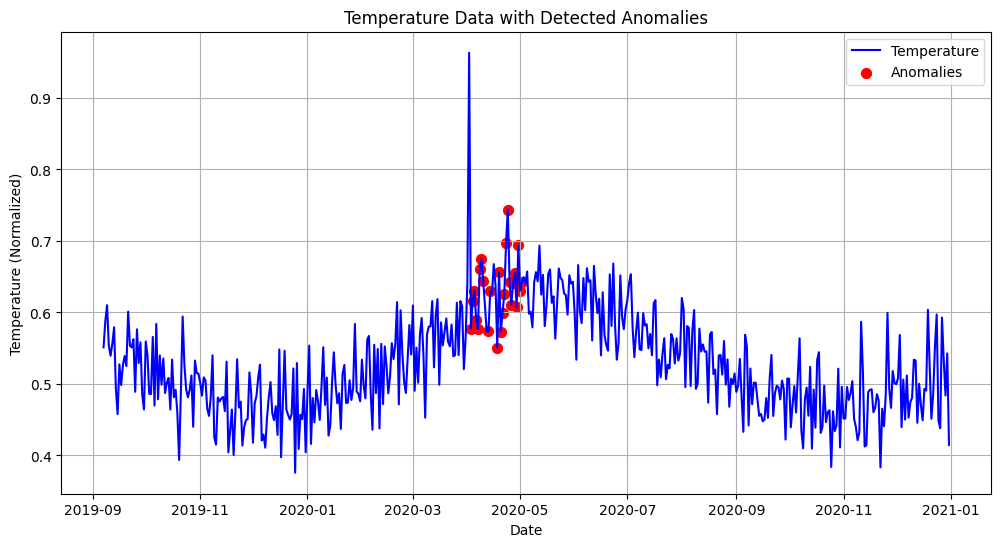

In [17]:
# Visualization: Highlight anomalies on the temperature curve
plt.figure(figsize=(12, 6))
plt.plot(test_data_with_errors['date'], test_data_with_errors['temperature'], label='Temperature', color='blue')
plt.scatter(anomalous_days['date'], anomalous_days['temperature'], color='red', label='Anomalies', s=50)
plt.xlabel('Date')
plt.ylabel('Temperature (Normalized)')
plt.title('Temperature Data with Detected Anomalies')
plt.legend()
plt.grid()
plt.show()


#### Final Interpretations:

*`Anomaly Clustering`*:
Most anomalies are detected in a short time window around March–April 2020, where the temperature shows noticeable deviations (spikes or irregular patterns).

*`Threshold Application`*:
The anomalies (red dots) align with points where the reconstruction error likely exceeded the threshold, and these points seem to represent either:

*`Sudden temperature increases or decreases`*.
Unusual temperature patterns not observed during training.

*`Other Periods`*:
The model doesn't flag anomalies for the rest of the data, where temperature trends appear smoother and more consistent with the model's learned patterns.

-----
-----